# 목적
- 마케팅 전략 수립을 위한 고객 군집화
- 군집별 고객의 특성 파악

In [48]:
# 기본 패키지 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 데이터 준비
- 출처
    - https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python
    - 원본 데이터셋의 컬럼명을 한글화 하였음
- 단위
    - 연간소득 : 천달러
    - 소비점수 : 1~100점

In [49]:
df = pd.read_csv("data/쇼핑몰고객군집화.csv")
df.head()

,고객ID,성별,나이,연간소득,소비점수
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# 데이터 전처리

## 사용할 컬럼 선택

In [50]:
X = df.drop(['고객ID'], axis=1)
X.head()

,성별,나이,연간소득,소비점수
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [51]:
# -----------------
# 데이터 유형 구분
# -----------------
cat_cols = X.select_dtypes(include='object').columns # 범주형 컬럼
num_cols = X.select_dtypes(include='number').columns # 수치형 컬럼

## 범주형 데이터 인코딩
- `drop='first'`
    - 범주형의 고윳값이 2개인 경우 하나의 컬럼만 사용

In [52]:
# -----------------
# 인코더 생성
# -----------------
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

# -----------------
# 인코딩
# -----------------
X_encoded = encoder.fit_transform(X[cat_cols])

# -----------------
# 인코딩 결과를 데이터프레임 형태로 만들기
# -----------------
X_encoded = pd.DataFrame(X_encoded, columns=['성별'])
X_encoded.head()

,성별
0,1.0
1,1.0
2,0.0
3,0.0
4,0.0


## 수치형 데이터 스케일링

In [53]:
# -----------------
# 스케일러 생성
# -----------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# -----------------
# 스케일링
# -----------------
X_scaled = scaler.fit_transform(X[num_cols])

# -----------------
# 스케일 된 데이터를 데이터프레임 형태로 만들기
# -----------------
X_scaled = pd.DataFrame(X_scaled, columns=num_cols)
X_scaled.head()


,나이,연간소득,소비점수
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


## 전처리 왼료된 최종 데이터

In [54]:
X_preporcessed = pd.concat([X_encoded, X_scaled], axis=1)
X_preporcessed.head()

,성별,나이,연간소득,소비점수
0,1.0,-1.424569,-1.738999,-0.434801
1,1.0,-1.281035,-1.738999,1.195704
2,0.0,-1.352802,-1.700830,-1.715913
3,0.0,-1.137502,-1.700830,1.040418
4,0.0,-0.563369,-1.662660,-0.395980


# k-means clustering

### 엘보우 기법으로 클러스터의 갯수 정하기

In [55]:
# -----------------
# 이너셔 구하기
# -----------------

min_cluster = 2
max_cluster = 10
random_state = 42

from sklearn.cluster import KMeans
inertia = []
for n in range(min_cluster,max_cluster):
    km = KMeans(n_clusters=n, random_state=random_state)
    km.fit(X_preporcessed)
    print(km.inertia_)
    inertia.append(km.inertia_)

438.52241155677746
345.2050346991059
254.36171423484498
216.7849015165104
181.9514362434146
171.37266048943806
153.29724063982397
142.71846488584745


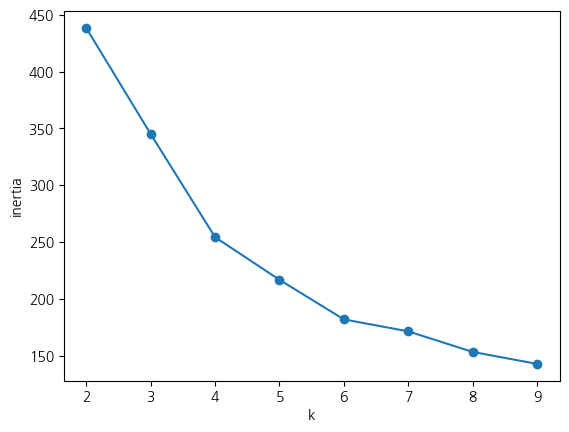

In [56]:
# -----------------
# 이너셔 시각화
# -----------------
plt.plot(range(min_cluster,max_cluster), inertia, marker='o')
plt.xticks(range(min_cluster,max_cluster))
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

## 실루엣 점수로 최적의 클러스터 갯수 찾기
- 실루엣 점수란?
    - 한 데이터가 자신의 클러스터 안에서는 얼마나 가깝고 다른 클러스터와는 얼마나 떨어져있는가를 측정한 값
    - 1에 가까울수록 잘 분리된 클러스터
    - 0에 가까울수록 클러스터간 경계가 애매함
    - 음수 -> 잘못된 군집 배정 가능성

In [57]:
# -----------------
# 군집 갯수에 따른 실루엣 점수
# -----------------
from sklearn.metrics import silhouette_score
for k in range(min_cluster, max_cluster):
    model = KMeans(n_clusters=k, random_state=random_state)
    labels = model.fit_predict(X_preporcessed)
    score = silhouette_score(X_preporcessed, labels)
    print(f"k = {k}, 실루엣 점수 = {score:.3f}")

k = 2, 실루엣 점수 = 0.303
k = 3, 실루엣 점수 = 0.312
k = 4, 실루엣 점수 = 0.350
k = 5, 실루엣 점수 = 0.350
k = 6, 실루엣 점수 = 0.356
k = 7, 실루엣 점수 = 0.332
k = 8, 실루엣 점수 = 0.336
k = 9, 실루엣 점수 = 0.312


## 클러스터링

In [58]:
k = 6
from sklearn.cluster import KMeans
km = KMeans(n_clusters=k, random_state=random_state, n_init=20)
km.fit(X_preporcessed)
df['군집'] = km.labels_
df.head()

,고객ID,성별,나이,연간소득,소비점수,군집
0,1,Male,19,15,39,4
1,2,Male,21,15,81,4
2,3,Female,20,16,6,2
3,4,Female,23,16,77,4
4,5,Female,31,17,40,2


# 군집분석

## 군집별 데이터 수

In [59]:
df['군집'].value_counts()

군집
0    45
1    39
5    38
3    34
4    23
2    21
Name: count, dtype: int64

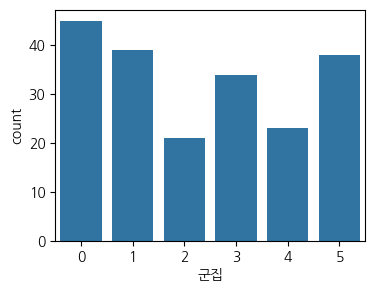

In [60]:
plt.figure(figsize=(4,3))
sns.countplot(x="군집", data=df);

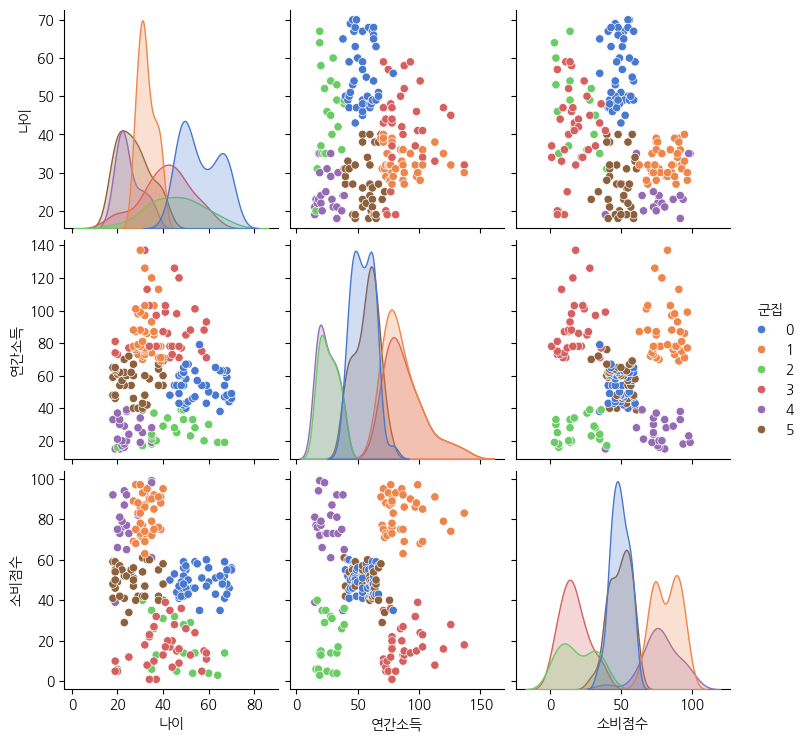

In [61]:
# -------------------
# 연속형 변수 시각화
# -------------------
sns.pairplot(df[["나이", "연간소득", "소비점수", "성별", "군집"]], 
             hue='군집', palette='muted');

## 성별

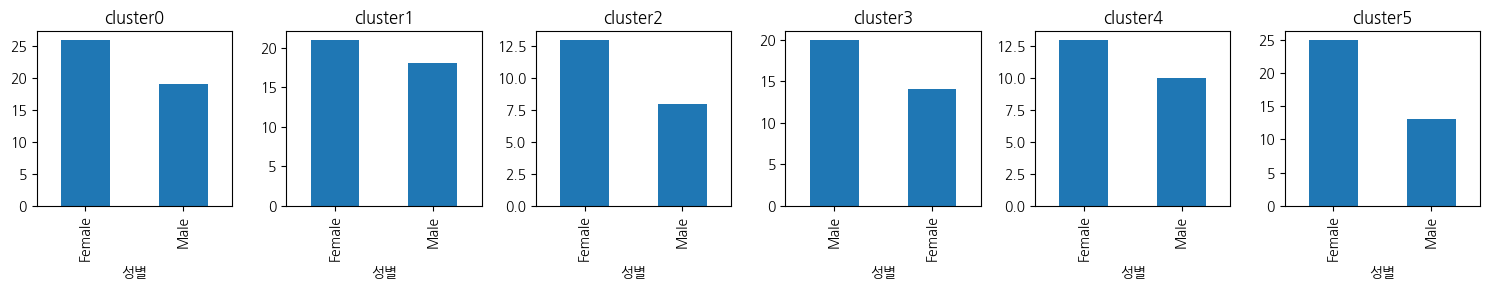

In [62]:
# -----------------------------
# 성별 빈도수 시각화
# -----------------------------
plt.figure(figsize=(15,3))
for i in range(k):
    plt.subplot(1,6,i+1)
    df.loc[df["군집"]==i, "성별"].value_counts().plot(kind="bar", title=f"cluster{i}")
    plt.tight_layout()

In [63]:
# -----------------------------
# 클러스터별 남성의 비율
#   0:0.42
#   1:0.46
#   2:0.38
#   3:0.59(남성비율이 더 높음)
#   4:0.43
#   4:0.34(여성비율이 가장 높음)
# -----------------------------
df['성별_이진'] = df['성별'].map({'Male':1, 'Female':0})
df[["성별_이진", "군집"]].groupby(by="군집").mean().round(2)

,성별_이진
군집,
0,0.42
1,0.46
2,0.38
3,0.59
4,0.43
5,0.34


# 

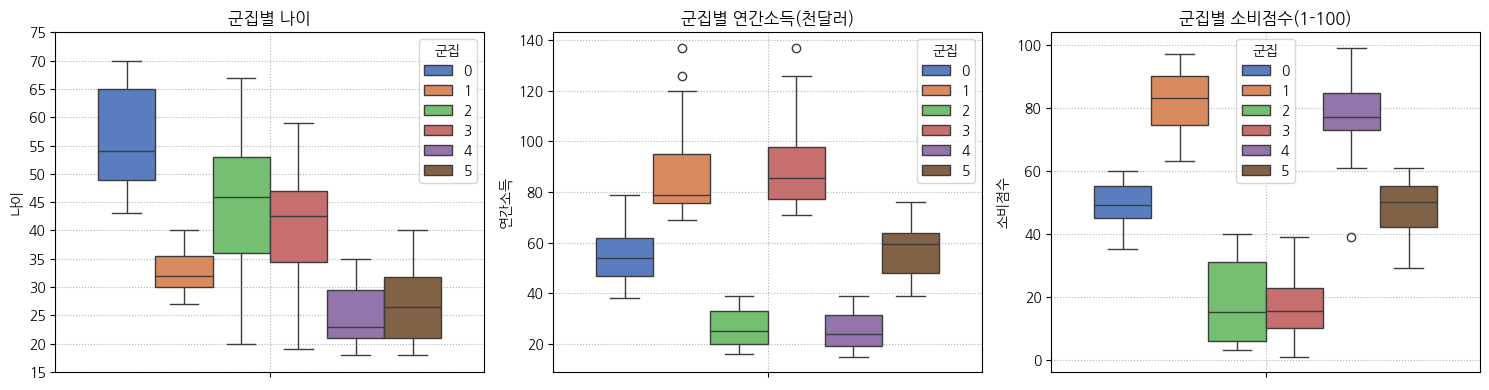

In [64]:
# -----------------------------
# "나이", "연간소득(천달러)", "소비점수(1-100)"
# -----------------------------
fig, ax = plt.subplots(1,3, figsize=(15,4))
sns.boxplot(y="나이", data=df, hue="군집", palette="muted", ax=ax[0])
sns.boxplot(y="연간소득", data=df, hue="군집", palette="muted", ax=ax[1])
sns.boxplot(y="소비점수", data=df, hue="군집", palette="muted", ax=ax[2])

ax[0].set_title('군집별 나이')
ax[0].set_yticks(range(15,80,5))
ax[0].grid(ls=':')

ax[1].set_title('군집별 연간소득(천달러)')
ax[1].grid(ls=':')

ax[2].set_title('군집별 소비점수(1-100)')
ax[2].grid(ls=':')

plt.tight_layout()

In [68]:
# -------------------
# 군집별 연령 범위
#   1: 43~70(높음)
#   2: 27~40(경제활동활발한나이)
#   3: 20~67(넓게분포)
#   4: 19~59(넓게분포)
#   5: 18~35(낮음)
#   6: 18~40(낮음)
# -------------------
df.groupby(by='군집')['나이'].agg(['min','max']) 

,min,max
군집,,
0,43,70
1,27,40
2,20,67
3,19,59
4,18,35
5,18,40


In [70]:
# -------------------
# 군집별 연간소득 범위 
#   1: 38~79(중간)
#   2: 69~137(높음)
#   3: 16~39(낮음)
#   4: 71~137(높음)
#   5: 15~29(낮음)
#   6: 39~76(중간)
# -------------------
df.groupby(by='군집')['연간소득'].agg(['min','max']) 

,min,max
군집,,
0,38,79
1,69,137
2,16,39
3,71,137
4,15,39
5,39,76


In [ ]:
# -------------------
# 군집별 소비점수 범위 
#   1: 35~60(중간)
#   2: 63~97(높음)
#   3: 3~40(낮음)
#   4: 1~39(낮음)
#   5: 39~99(높음)
#   6: 29~61(중간)
# -------------------
df.groupby(by='군집')['소비점수'].agg(['min','max']) 

,min,max
군집,,
0,35,60
1,63,97
2,3,40
3,1,39
4,39,99
5,29,61


# 군집화 분석 결과


|클러스터|0|1|2|3|4|5|
|---|---|---|---|---|---|---|
|남성비율|0.42|0.46|0.38|**0.59**|0.43|0.34|
|연령|43~70(높음)|27~40(경제활동활발한연령)|20~67(넓게분포)|19~59(비교적넓게분포)|18~35(낮음)|18~40(낮음)|
|연간소득|38~79(중간)|69~137(높음)|16~39(낮음)|71~137(높음)|15~39(낮음)|39~76(중간)|
|소비점수|35~60(중간)|63~97(높음)|3~40(낮음)|1~39(낮음)|39~99(높음)|29~61(중간)|